In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

In [1]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

#from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../Repository/input'
outDir = '../output'
modelDir = '../models'
subDir = 'weather'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 20 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'medium',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [4]:
# Check if all directories are present
# if not os.path.exists(os.path.join(outDir)):
#     os.makedirs(os.path.join(outDir))
#     print ('Created {} directory'.format(outDir))

# if not os.path.exists(os.path.join(modelDir, subDir)):
#     os.makedirs(os.path.join(modelDir, subDir))
#     print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Read weather data

In [5]:
data_df  = pd.read_csv(os.path.join(inpDir, 'weatherHistory.csv'))
# data_df = pd.read_csv(r'C:\Users\Administrator.DAI-PC2\Desktop\PGDAI\5. DNN\Repository\input\weatherHistory.csv')
data_df.shape

(96453, 12)

In [6]:
data_df.shape

(96453, 12)

# Take due care of timezone

In [7]:
# removing rows with position = null
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'],utc = True)
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,datetime
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,2006-03-31 22:00:00+00:00
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,2006-03-31 23:00:00+00:00
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,2006-04-01 00:00:00+00:00
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,2006-04-01 01:00:00+00:00
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,2006-04-01 02:00:00+00:00


In [8]:
data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temperature (C),96453.0,11.932678,9.551546,-21.822222,4.688889,12.0000,18.838889,39.905556
Apparent Temperature (C),96453.0,10.855029,10.696847,-27.716667,2.311111,12.0000,18.838889,39.344444
Humidity,96453.0,0.734899,0.195473,0.000000,0.600000,0.7800,0.890000,1.000000
Wind Speed (km/h),96453.0,10.810640,6.913571,0.000000,5.828200,9.9659,14.135800,63.852600
Wind Bearing (degrees),96453.0,187.509232,107.383428,0.000000,116.000000,180.0000,290.000000,359.000000
Visibility (km),96453.0,10.347325,4.192123,0.000000,8.339800,10.0464,14.812000,16.100000
Loud Cover,96453.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
Pressure (millibars),96453.0,1003.235956,116.969906,0.000000,1011.900000,1016.4500,1021.090000,1046.380000


In [9]:
data_df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary', 'datetime'],
      dtype='object')

In [10]:
# Following columns appear to be relevant for our analysis
num_col = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)','Wind Bearing (degrees)', 'Visibility (km)','Pressure (millibars)']
len(num_col)

6

## HistPlot

c:\Users\Administrator.DAI-PC2\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Administrator.DAI-PC2\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Administrator.DAI-PC2\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Administrator.DAI-PC2\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

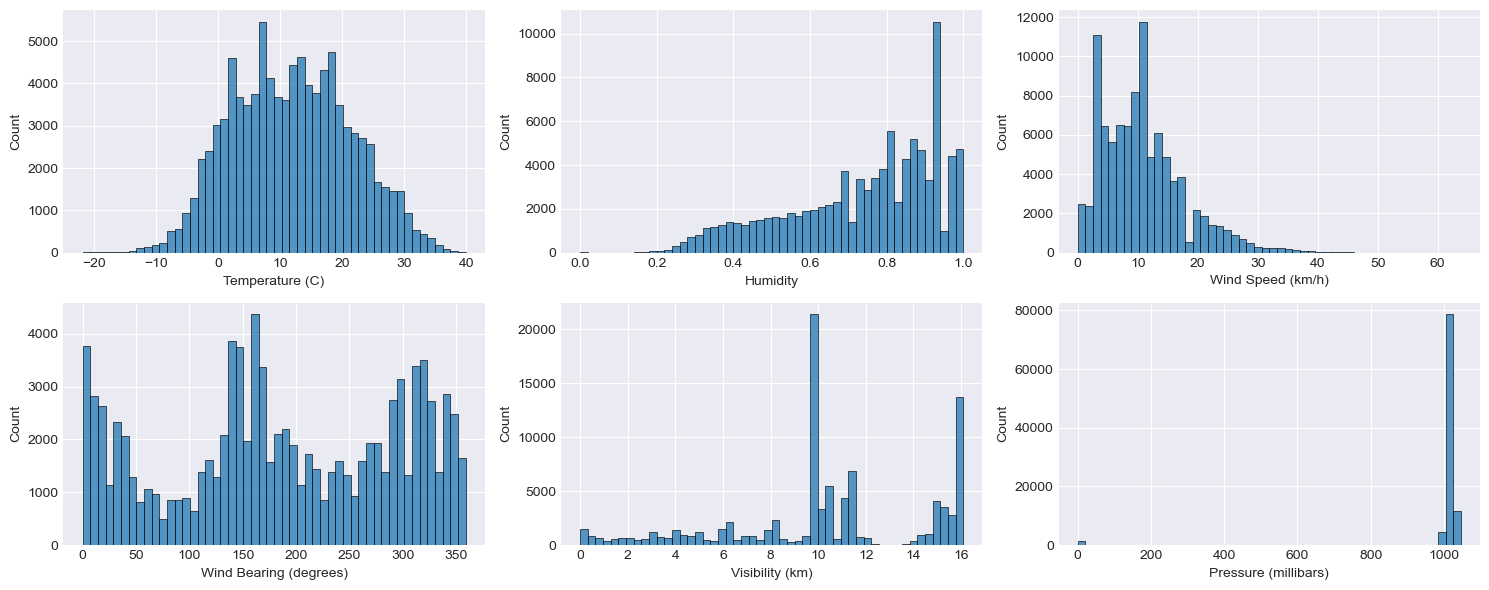

In [11]:
fig,axes = plt.subplots(2,3)
axes = axes.ravel()
for count,col in enumerate(num_col):
    ax = axes[count]
    sns.histplot(data_df,x=col,ax=ax,bins=50)
plt.tight_layout()


## Boxplot

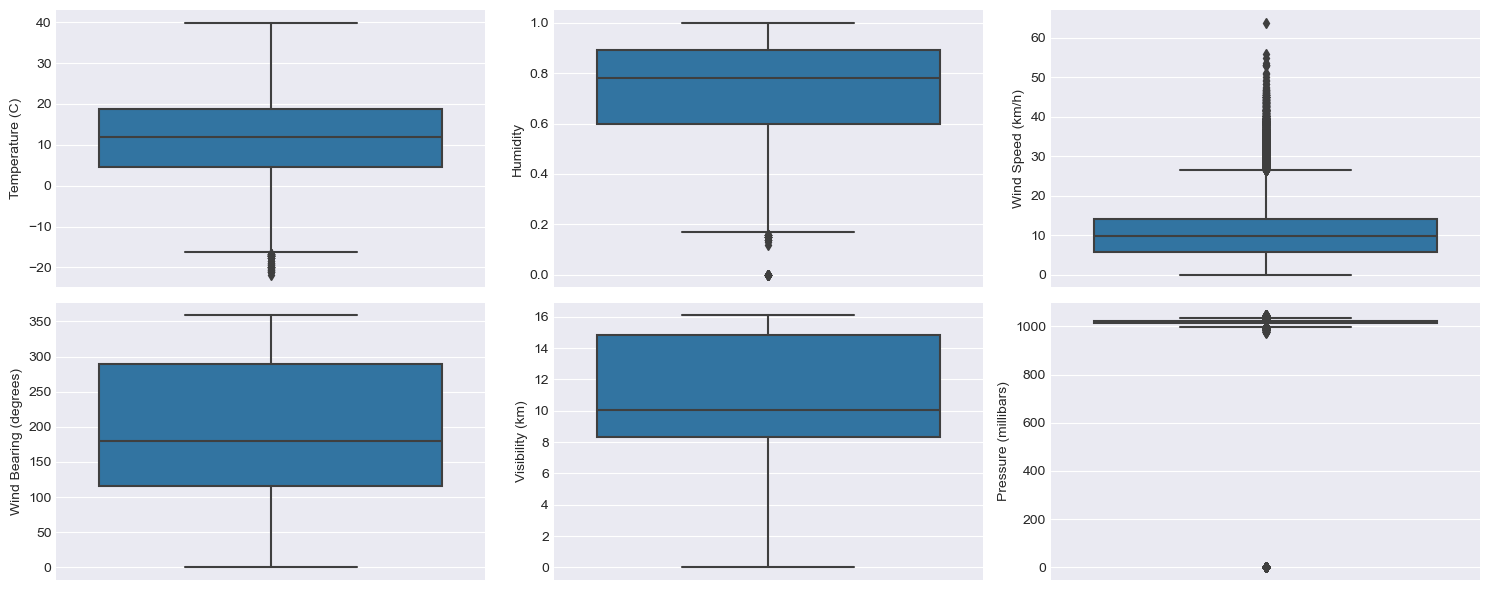

In [12]:
fig,axes = plt.subplots(2,3)
axes = axes.ravel()
for count,col in enumerate(num_col):
    ax = axes[count]
    sns.boxplot(data=data_df,y=col,ax=ax)
plt.tight_layout()

In [13]:
cor = data_df[num_col].corr()

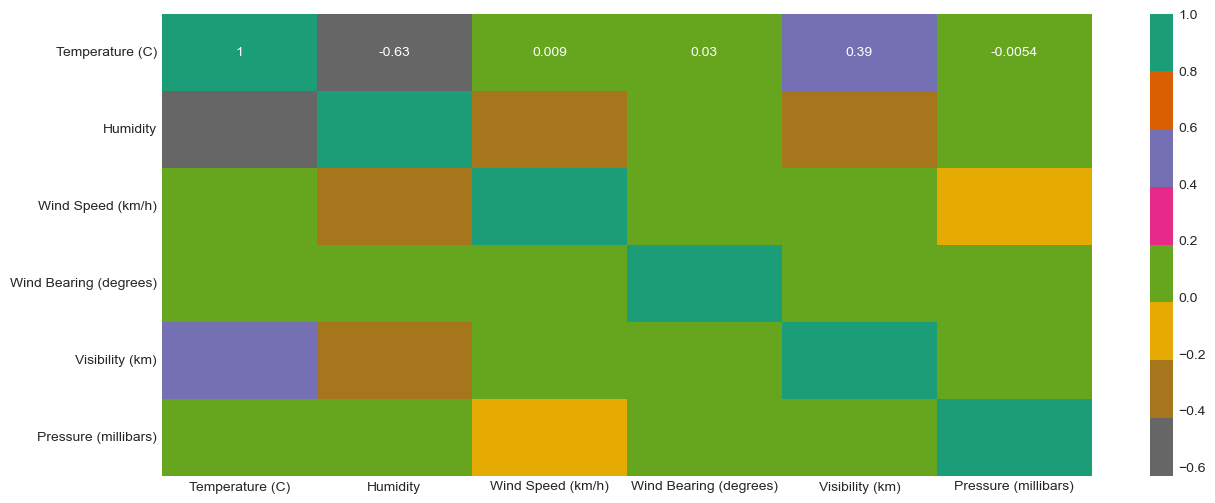

In [14]:
sns.heatmap(cor,annot=True,cmap='Dark2_r');

In [15]:
tmp_df = data_df[['datetime','Temperature (C)','Visibility (km)','Humidity']]

tmp_df = tmp_df.sort_values('datetime',axis=0,ascending=True)
tmp_df = tmp_df.reset_index(drop=True)
tmp_df.head()

,datetime,Temperature (C),Visibility (km),Humidity
0,2005-12-31 23:00:00+00:00,0.577778,9.9820,0.89
1,2006-01-01 00:00:00+00:00,1.161111,9.9015,0.85
2,2006-01-01 01:00:00+00:00,1.666667,9.9015,0.82
3,2006-01-01 02:00:00+00:00,1.711111,9.9015,0.82
4,2006-01-01 03:00:00+00:00,1.183333,9.9015,0.86


In [16]:
tmp_df = tmp_df.rename({'Temperature (C)':'temp','Visibility (km)':'viz','Humidity':'hum'},axis=1)
tmp_df.head()

,datetime,temp,viz,hum
0,2005-12-31 23:00:00+00:00,0.577778,9.9820,0.89
1,2006-01-01 00:00:00+00:00,1.161111,9.9015,0.85
2,2006-01-01 01:00:00+00:00,1.666667,9.9015,0.82
3,2006-01-01 02:00:00+00:00,1.711111,9.9015,0.82
4,2006-01-01 03:00:00+00:00,1.183333,9.9015,0.86


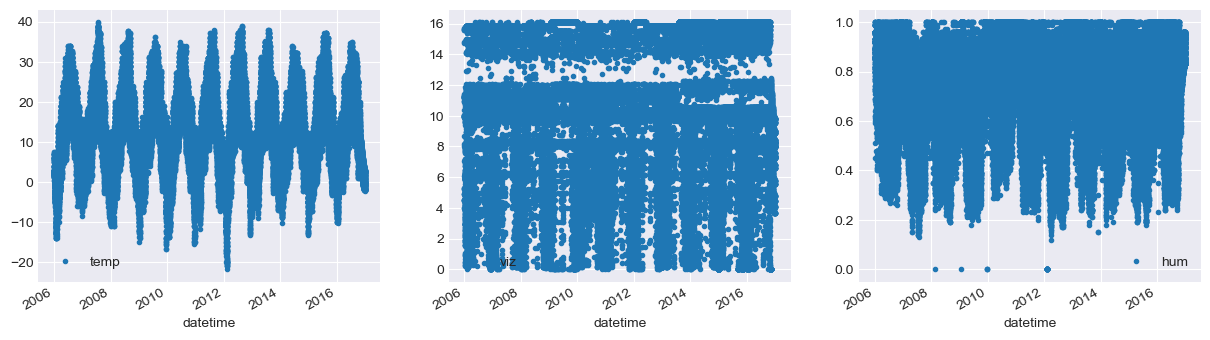

In [21]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,3,1)
tmp_df.plot(x='datetime',y='temp',style='.',ax=ax);

ax = fig.add_subplot(1,3,2)
tmp_df.plot(x='datetime',y='viz',style='.',ax=ax);

ax = fig.add_subplot(1,3,3)
tmp_df.plot(x='datetime',y='hum',style='.',ax=ax);

In [22]:
h_units = 100
input_shape = (1,10000)
model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(units=h_units,
                                    input_shape = input_shape,
                                    activation = 'tanh'    
))

model.add(tf.keras.layers.Dense(1,activation='linear'))

In [23]:
wax = model.get_weights()[0].shape
waa = model.get_weights()[1].shape
baa = model.get_weights()[2].shape
way = model.get_weights()[3].shape
bay = model.get_weights()[4].shape
wax,waa,baa,way,bay

((10000, 100), (100, 100), (100,), (100, 1), (1,))

In [26]:
time_step = 24
y_idx = np.arange(time_step,tmp_df.shape[0],time_step)
y_df = tmp_df.iloc[y_idx]
y_df.shape

(4018, 4)

In [27]:
y_df.shape[0]*time_step

96432

In [28]:
X_df = tmp_df.iloc[range(len(y_df)*time_step)]
X_df.shape

(96432, 4)

In [30]:
X_temp= np.reshape(X_df['temp'].to_numpy(),
               (y_df.shape[0],time_step))
X_hum = np.reshape(X_df['hum'].to_numpy(),
               (y_df.shape[0],time_step))
X_viz = np.reshape(X_df['viz'].to_numpy(),
               (y_df.shape[0],time_step))

In [31]:

X_temp = X_temp[:,:23]
X_hum = X_hum[:,:23]
X_viz = X_viz[:,:23]

Input shape expected = '[batch,timesteps,feature]'

In [32]:
X_data =  np.stack((X_temp, X_hum), axis =2)

X_data.shape

(4018, 23, 2)

In [34]:
split = int(y_df.shape[0]*(1-TEST_SIZE))
X_train = X_data[:split]
X_test = X_data[split:]
y_train = y_df['temp'].to_numpy()[:split]
y_test = y_df['temp'].to_numpy()[split:]
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((3214, 23, 2), (804, 23, 2), (3214,), (804,))

In [35]:
h_units = 256
input_shape = ( time_step -1 , X_train.shape[2] )
model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(units=h_units,
                                    input_shape = input_shape,
                                    activation = 'tanh'    
))

model.add(tf.keras.layers.Dense(1,activation='linear'))

model.compile(loss = 'mean_squared_error', 
              metrics=[tf.keras.metrics.RootMeanSquaredError()],
              optimizer='adam')

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 256)               66304     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 66561 (260.00 KB)
Trainable params: 66561 (260.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
history = model.fit(X_train,
                     y_train,
                       epochs=EPOCHS,
                         batch_size = BATCH_SIZE,
                           validation_data = [X_test, y_test],
                             verbose=True)

Epoch 1/20

101/101 [==============================] - 4s 22ms/step - loss: 9.1899 - root_mean_squared_error: 3.0315 - val_loss: 1.1898 - val_root_mean_squared_error: 1.0908
Epoch 2/20
101/101 [==============================] - 2s 17ms/step - loss: 1.5916 - root_mean_squared_error: 1.2616 - val_loss: 1.2634 - val_root_mean_squared_error: 1.1240
Epoch 3/20
101/101 [==============================] - 2s 16ms/step - loss: 1.4002 - root_mean_squared_error: 1.1833 - val_loss: 1.1845 - val_root_mean_squared_error: 1.0884
Epoch 4/20
101/101 [==============================] - 2s 19ms/step - loss: 1.2333 - root_mean_squared_error: 1.1106 - val_loss: 0.7740 - val_root_mean_squared_error: 0.8798
Epoch 5/20
101/101 [==============================] - 2s 18ms/step - loss: 1.2733 - root_mean_squared_error: 1.1284 - val_loss: 1.0286 - val_root_mean_squared_error: 1.0142
Epoch 6/20
101/101 [==============================] - 2s 18ms/step - loss: 1.1340 - root_mean_squared_error: 1.0649 - val_loss: 0.7071

In [38]:
loss_df = pd.DataFrame(history.history)
loss_df

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,9.189937,3.031491,1.189810,1.090784
1,1.591639,1.261602,1.263394,1.124008
2,1.400173,1.183289,1.184534,1.088363
3,1.233347,1.110561,0.773988,0.879766
4,1.273258,1.128387,1.028551,1.014175
5,1.133953,1.064872,0.707115,0.840901
6,1.100040,1.048828,0.715735,0.846011
7,1.057386,1.028293,0.721305,0.849297
8,1.040835,1.020213,0.720679,0.848928
9,1.021160,1.010524,0.935162,0.967038


In [39]:
###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    



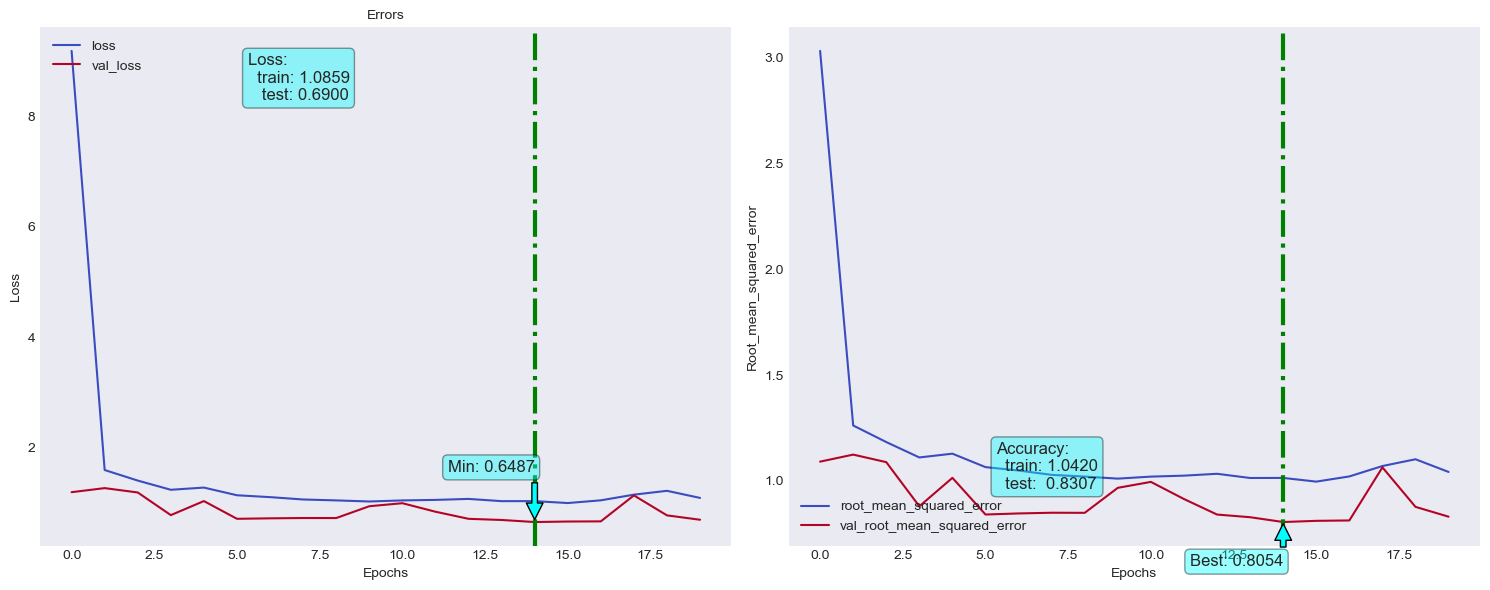

In [40]:
fn_plot_tf_hist(loss_df)

In [41]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_pred = np.append(y_train_pred, y_test_pred)

y_pred.shape

26/26 [==============================] - 0s 7ms/step


(4018,)

In [42]:
res_df = y_df.copy()
res_df['pred'] = y_pred
res_df['datetime'] = res_df['datetime'].dt.date
res_df

,datetime,temp,viz,hum,pred
24,2006-01-01,5.422222,15.6492,0.86,4.831345
48,2006-01-02,1.694444,4.4919,0.92,1.229749
72,2006-01-03,2.200000,9.5795,0.89,1.771082
96,2006-01-04,1.666667,9.9015,0.92,1.658641
120,2006-01-05,1.805556,2.2057,0.99,2.014874
...,...,...,...,...,...
96336,2016-12-27,-1.627778,6.6010,0.95,-1.754620
96360,2016-12-28,-1.677778,6.6010,0.95,-1.808437
96384,2016-12-29,-1.727778,6.6010,0.95,-1.862142
96408,2016-12-30,-1.777778,6.6171,0.95,-1.915285


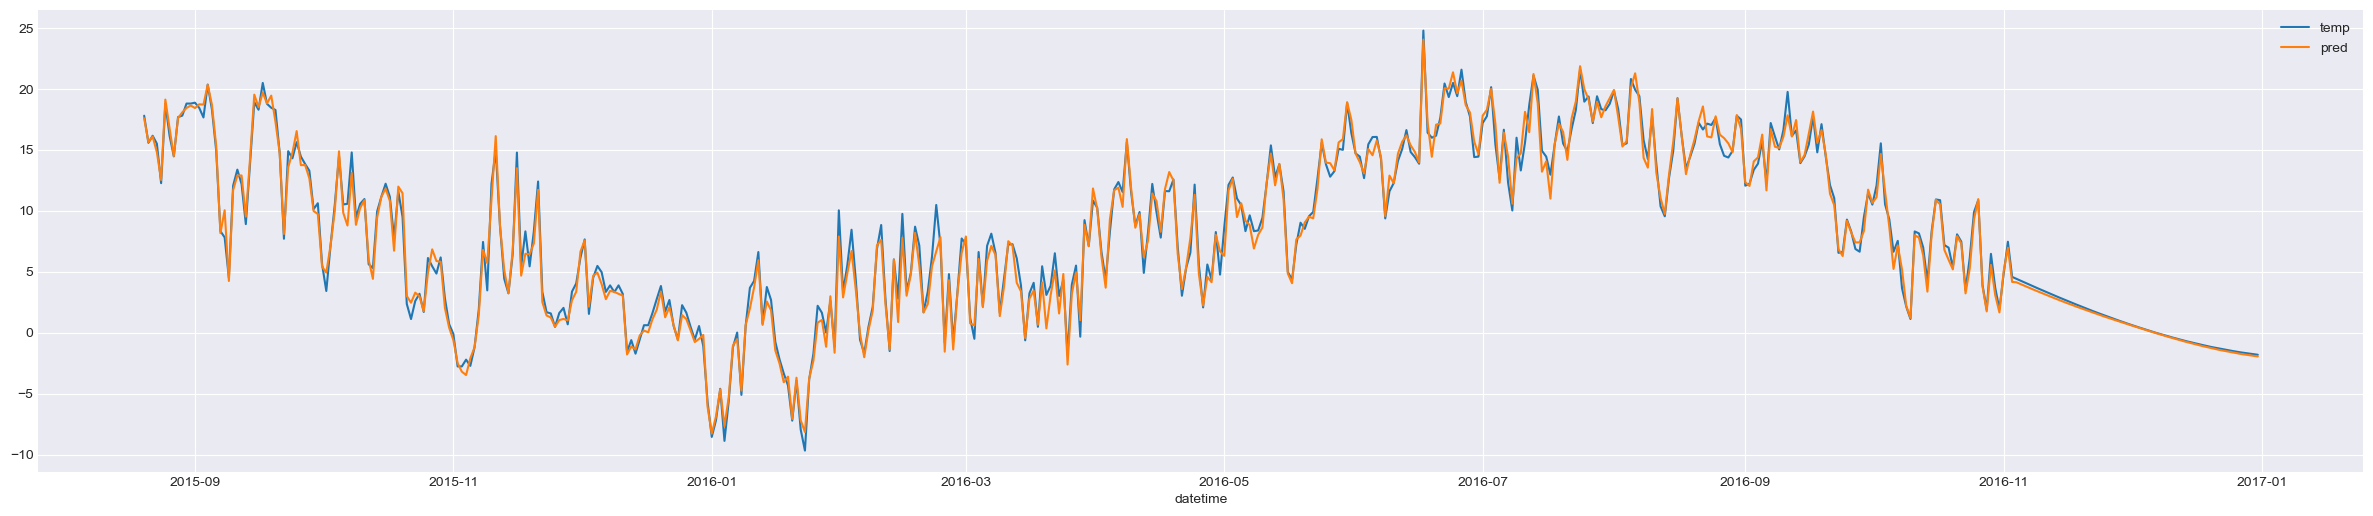

In [43]:
fig, ax = plt.subplots(figsize=(30,6))
res_df[-500:].plot(x = 'datetime', y=['temp','pred'], ax=ax);